In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

def torch_train_val_split(dataset, batch_train, batch_eval,val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])



class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value
    #https://stackoverflow.com/questions/9663562/what-is-the-difference-between-init-and-call
    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            #https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1
        
class MultiDatasetCnn(Dataset): ## expanding dimensions...
    def __init__(self, path ,train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('float32')
        #print([f.shape for f in self.feats] )

    def get_files_labels(self, txt):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            l = l[0].split(',')
            _id = l[0]
            label = l[1:] # load all labels, valence,energy,danceability
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    

    def __getitem__(self, item):
        l = min(self.lengths[item], self.max_length)
        return np.expand_dims(self.zero_pad_and_stack(self.feats[item]), 0), self.labels[item], l
        
    
    def __len__(self):
        return len(self.labels)

In [2]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [3]:
data = MultiDatasetCnn('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/', train=True, max_length=-1) 
train_loader, val_loader = torch_train_val_split(data, 32 ,32, val_size=.2, shuffle=True)
test_loader = DataLoader(data, batch_size=32)

In [4]:
import torch.nn as nn
import torch
class Layers(nn.Module):
    def __init__(self,in_c,out_c):
        super(Layers,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_c,kernel_size=5,out_channels=out_c,stride=1,padding=2)
        self.bn = nn.BatchNorm2d(num_features=out_c)
        self.pool = nn.MaxPool2d(2, 2)
        self.tanh = nn.Tanh()

    def forward(self,x):
        output = self.conv(x.float())
        output = self.bn(output)
        output = self.tanh(output)
        output = self.pool(output)
        return output

class BasicCNN(nn.Module):
    def __init__(self, classes):
        super(BasicCNN, self).__init__()
        self.classes = classes
        self.l1 = Layers(in_c=1, out_c=16)
        self.l2 = Layers(in_c=16, out_c=8)
        self.l3 = Layers(in_c=8, out_c=4)
        self.l4 = Layers(in_c=4, out_c=2)
        self.net = nn.Sequential(self.l1, self.l2, self.l3, self.l4)
        self.fc1 = nn.Linear(8 * 80 * 2, self.classes)
        
    def forward(self, x):
        output = self.net(x)
        output = output.view(-1, 8 * 80 * 2)
        output = self.fc1(output)
        return output


In [5]:
model = BasicCNN(3)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

In [6]:
dataloaders = {'train':train_loader,'val':val_loader}

In [7]:
def trainCNN(model,dataloaders,num_epochs,optimizer,patience,crit=False):
    Flag=False
    # for loss
    val_loss = []
    train_loss = []
    phase1 = dataloaders.keys()
    criterion = nn.MSELoss()
    train_loader = dataloaders['train']
    if(torch.cuda.is_available()):
        device = 0
        model.to(device)
    else:
        device = 'cpu'
        model.to(device)
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        counter = epoch # keeping this variable for plot function after for loop
        if Flag == True:
            break
        print('Epoch:',epoch + 1)
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for  batch_idx, data in enumerate(dataloaders[phase]):
                optimizer.zero_grad()
                output = model(data[0].to(device)).to(device)
                loss_valence= criterion(output.squeeze()[:,0], data[1][:,0].to(device))
                loss_energy = criterion(output.squeeze()[:,1], data[1][:,1].to(device))
                loss_dance  = criterion(output.squeeze()[:,2], data[1][:,2].to(device))
                
                sum_losses = torch.sum(torch.stack([loss_valence,loss_energy,loss_dance]))
                epoch_metrics["loss"].append(sum_losses.item())
                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
                % (
                    epoch + 1,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    sum_losses.item(),
                    np.mean(epoch_metrics["loss"])
                    )
                )

                if(phase =='train'):
                    sum_losses.backward()
                    optimizer.step()
            
            epoch_loss = np.mean(epoch_metrics["loss"])
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else: 
                val_loss.append(epoch_loss)
            if(phase == 'val' and patience !=None):
                earlystop(epoch_loss,model)
                if(earlystop.early_stop):
                    print("Early stopping")
                    model.load_state_dict(torch.load('./checkpoint.pt'))
                    #break
                    Flag = True
    if counter == num_epochs -1:
        epochs_axis = np.arange(num_epochs)
    else:
        epochs_axis = np.arange(counter)
    plt.plot(epochs_axis, train_loss,color='red')
    plt.plot(epochs_axis, val_loss,color='blue')
    plt.legend(['training-red', 'validation-blue'], loc='upper left')
    plt.show()

Epoch: 1
[Epoch 1/20] [Batch 6/7] [Loss: 0.324305 (0.398683)]Validation loss decreased (inf --> 0.398683).  Saving model ...
Epoch: 2
[Epoch 2/20] [Batch 6/7] [Loss: 0.212395 (0.168522)]Validation loss decreased (0.398683 --> 0.168522).  Saving model ...
Epoch: 3
[Epoch 3/20] [Batch 6/7] [Loss: 0.191258 (0.140427)]Validation loss decreased (0.168522 --> 0.140427).  Saving model ...
Epoch: 4
[Epoch 4/20] [Batch 6/7] [Loss: 0.149378 (0.137646)]Validation loss decreased (0.140427 --> 0.137646).  Saving model ...
Epoch: 5
[Epoch 5/20] [Batch 6/7] [Loss: 0.208894 (0.114255)]Validation loss decreased (0.137646 --> 0.114255).  Saving model ...
Epoch: 6
[Epoch 6/20] [Batch 6/7] [Loss: 0.162571 (0.123257)]EarlyStopping counter: 1 out of 3
Epoch: 7
[Epoch 7/20] [Batch 6/7] [Loss: 0.162289 (0.098725)]Validation loss decreased (0.114255 --> 0.098725).  Saving model ...
Epoch: 8
[Epoch 8/20] [Batch 6/7] [Loss: 0.110890 (0.095304)]Validation loss decreased (0.098725 --> 0.095304).  Saving model ...


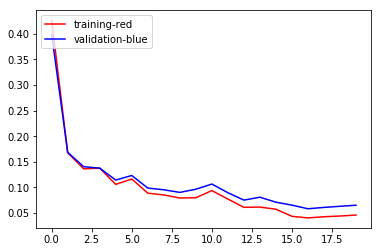

In [8]:
trainCNN(model,dataloaders,20,optimizer,3)

Predict on Test set

In [9]:
def CNN_REG(test_loader, model, criterion,device=0):
    
    test_loss = []
    predictions = []
    ytest  = []
    predictions_dance, y_test_dance = [], []
    model.eval()
    model.to(0)
    for i_batch, data_batched in enumerate(test_loader, 0):
        data_batched[0], data_batched[2] = data_batched[0].to(0), data_batched[2].to(0)
        output = model(data_batched[0]).to(0)
        
        predictions_val , predictions_en , predictions_dance = output.squeeze()[:,0],output.squeeze()[:,1],output.squeeze()[:,2]
        y_test_val , y_test_en , y_test_dance =  data_batched[1][:,0].to(device),data_batched[1][:,1].to(device),data_batched[1][:,2].to(device)
        
        loss_valence= criterion(predictions_val,   y_test_val)
        loss_energy = criterion(predictions_en,    y_test_en)
        loss_dance  = criterion(predictions_dance, y_test_dance)
        
        loss = torch.sum(torch.stack([loss_valence,loss_energy,loss_dance]))
        test_loss.append(loss.item()) 
        
        preds1 = predictions_val.data.cpu().numpy()
        preds2 = predictions_en.data.cpu().numpy()
        preds3 = predictions_dance.data.cpu().numpy()
        
        predictions += list(preds1)
        predictions += list(preds2)
        predictions += list(preds3)
    
        ytest += list(y_test_val.data.cpu().numpy())  
        ytest += list(y_test_en.data.cpu().numpy()) 
        ytest += list(y_test_dance.data.cpu().numpy()) 
        
    total_loss = np.mean(test_loss)
    print('Test loss: {}'.format(total_loss))
    return predictions, ytest

In [10]:
criterion_regr = nn.MSELoss()
predictions_cnn, labels_cnn = CNN_REG(test_loader, model, criterion_regr)
spearmanr(labels_cnn, predictions_cnn)

Test loss: 0.05702364962134096


SpearmanrResult(correlation=0.826440821303077, pvalue=0.0)

Παρατηρούμε πως πετύχαμε loss περίπου 0.1 με καλό correlation το οποίο είναι στατιστικά σημαντικό.

* Υποβολή στο kaggle. Αλλάζουμε τη συνάρτηση με το dataset ώστε να διαβάσουμε τα δεδομένα στο φάκελο test.

In [36]:
class MultiDatasetCnn2(Dataset): ## expanding dimensions...
    def __init__(self,  max_length=-1, read_spec_fn=read_fused_spectrogram):
        #t = 'train' if train else 'test'
        path = '/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test'
        p = os.listdir('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test')
        #self.index = os.path.join(path, "{}_labels.txt".format(t))
        #self.files, labels = self.get_files_labels(self.index)
        files = []
        for i in p:
            files.append(os.path.join(path,i))
        self.feats = [read_spec_fn(f) for f in files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        
        if isinstance(p, (list, tuple)):
            self.p = np.array(p)
        #print([f.shape for f in self.feats] )

    def get_files_labels(self, txt):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            l = l[0].split(',')
            _id = l[0]
            label = l[1:] # load all labels, valence,energy,danceability
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    

    def __getitem__(self, item):
        l = min(self.lengths[item], self.max_length)
        return np.expand_dims(self.zero_pad_and_stack(self.feats[item]), 0), self.p[item] 
        
    
    def __len__(self):
        return len(self.feats)



data = MultiDatasetCnn2(max_length=-1) 
test_loader = DataLoader(data, batch_size=32)

In [ ]:
#os.path.join('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test','fo')

In [20]:
#os.listdir('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test')[0]

'7659.fused.full.npy'

In [21]:
#os.path.join('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test','7659.fused.full.npy')

'/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/7659.fused.full.npy'

In [48]:
def CNN_REG(test_loader, model, criterion,device=0):
    
    #test_loss = []
    #predictions = []
    #ytest  = []
    pred_id,predictions_valence, predictions_energy,predictions_danceability = [], [], [] , []
    model.eval()
    model.to(device)
    for i_batch, data_batched in enumerate(test_loader, 0):
        data_batched[0] = data_batched[0].to(device)
        #print(data_batched[1])
        data_batched[1] =  data_batched[1]#.to(device)
        output = model(data_batched[0]).to(device)
        
        predictions_val , predictions_en , predictions_dance = output.squeeze()[:,0],output.squeeze()[:,1],output.squeeze()[:,2]
        #y_test_val , y_test_en , y_test_dance =  data_batched[1][:,0].to(device),data_batched[1][:,1].to(device),data_batched[1][:,2].to(device)
        predictions_valence += list(predictions_val.data.cpu().numpy())
        predictions_energy += list(predictions_en.data.cpu().numpy())
        predictions_danceability += list(predictions_dance.data.cpu().numpy())
        pred_id += list(data_batched[1])
        
    #total_loss = np.mean(test_loss)
    #print('Test loss: {}'.format(total_loss))
    return pred_id,predictions_valence,predictions_energy, predictions_danceability

In [49]:
pid,val,en,dance = CNN_REG(test_loader, model, criterion_regr,device='cpu')

In [51]:
solution = pd.DataFrame({'Id.fused.full.npy':pid,'valence':val,'energy':en,'danceability':dance})
solution.head()

,Id.fused.full.npy,valence,energy,dance
0,7659.fused.full.npy,0.780193,0.736285,0.754877
1,1704.fused.full.npy,0.637906,0.499492,0.610718
2,9250.fused.full.npy,0.631738,0.898681,0.421798
3,1652.fused.full.npy,0.636361,0.922732,0.609474
4,2514.fused.full.npy,0.478625,0.514503,0.709588


In [52]:
filename = 'solution.txt'
solution.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: solution.txt
